# Credits

Originally created for a previous version of the [02456-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning) course material, but [converted to PyTorch](https://github.com/pytorch/tutorials).
See repos for credits.

# Dependancies and supporting functions
Loading dependancies and supporting functions by running the code block below.

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  import matplotlib


# Cuda semantics in PyTorch

> **NB:** If at possible you should run this notebooks using a GPU, i.e. use nvidia-docker and run the gpu image (training time is ~ 30 minutes on a new-ish laptop using the CPU).
> If you don't have a GPU, and training takes too long consider reducing the dataset size of the dataset.

When we train larger models it becomes infeasible to run on CPUs.
Thankfully, GPU support is straightforward in PyTorch.

See the [docs on cuda functionality](http://pytorch.org/docs/master/cuda.html) for an overview of useful functions for use with cuda.
For more examples on cuda semantics see [the notes here](http://pytorch.org/docs/master/notes/cuda.html#cuda-semantics).


## Transfer tensor to GPU

Tensors can be transferred to the GPU by applying the `.cuda()` method to the 
[`torch.Tensor`s](http://pytorch.org/docs/master/tensors.html#torch-tensor) and 
[`torch.autograd.Variable`s](http://pytorch.org/docs/master/autograd.html#torch.autograd.Variable), e.g. `inputs.cuda()`.

## Transfer network to GPU

Just like how you transfer a Tensor on to the GPU, you transfer the entire network onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
net.cuda()

```    

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
outputs = net(inputs)
loss = criterion(outputs, labels)
```

## Use the cuda tensors / variables on CPU

When tensors, modules, etc. are on a GPU they are no longer regular `torch.Tensor`s, but `torch.cuda.Tensor`s (see [torch's tensor overview](http://pytorch.org/docs/master/tensors.html#torch-tensor)).
To be able to work with them on the host's memory, you need to fetch them from the GPU first.

Given a cuda tensor or variable `ct` you can move it to host memory with `ct.cpu()`.
If for instance you want to convert the tensor in a variable to numpy, you call `ct.cpu().data.numpy()`.
If it was not on the GPU, we would not need the `.cpu()` call.

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

## Multiple GPUs

When you need to run a model on multiple GPUs you can use either 
[torch.nn.DataParallel](http://pytorch.org/docs/master/nn.html#torch.nn.DataParallel) or 
[torch.nn.parallel.DistributedDataParallel](http://pytorch.org/docs/master/nn.html#torch.nn.parallel.DistributedDataParallel).
Depending on whether the GPUs are on multiple machines and how many CPUs you can utilize for handling the training.
If you have more than two GPUs DitributedDataParallel is usually the better choice.

It is straightforward to use this. Simply wrap the model as follows

```
model = Net() # define the model as always
net = torch.nn.DataParallel(model, device_ids=None) # tell pytorch to use all available cuda devices
output = net(input_var) # run on all devices
```

Check out [the data parallel example](http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html) if you want to know more.

In [3]:
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()
    return x.data.numpy()

# More Fun with convolutional networks
## Get the data

For this exercise we will use a modified version of MNIST - **MNIST Cluttered**.
In the data the each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas.
To make the task harder each canvas has then been cluttered with small pieces of digits.


In [5]:
!if [ ! -f mnist_cluttered_60x60_6distortions.npz ]; then wget -N https://www.dropbox.com/s/rvvo1vtjjrryr7e/mnist_cluttered_60x60_6distortions.npz; else echo "mnist_cluttered_60x60_6distortions.npz already downloaded"; fi

mnist_cluttered_60x60_6distortions.npz already downloaded


## Spatial Transformer Networks

In this task it is helpfull for a network if it can focus only on the digit and ignore the rest.
The ``TransformerLayer`` lets us do this.
The transformer layer learns an affine transformation which lets the network zoom, rotate and skew.
If you are interested you should [read the paper](https://arxiv.org/abs/1506.02025), but the main idea is that you can let a small convolutional network determine the the parameters of the affine transformation.
You then apply the affine transformation to the input data.
Usually this also involves downsampling which forces the model to zoom in on the relevant parts of the data.
After the affine transformation we can use a larger conv net to do the classification. 
This is possible because you can backprop through an affine transformation if you use bilinear interpolation.

In [6]:
NUM_EPOCHS = 15
BATCH_SIZE = 256
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


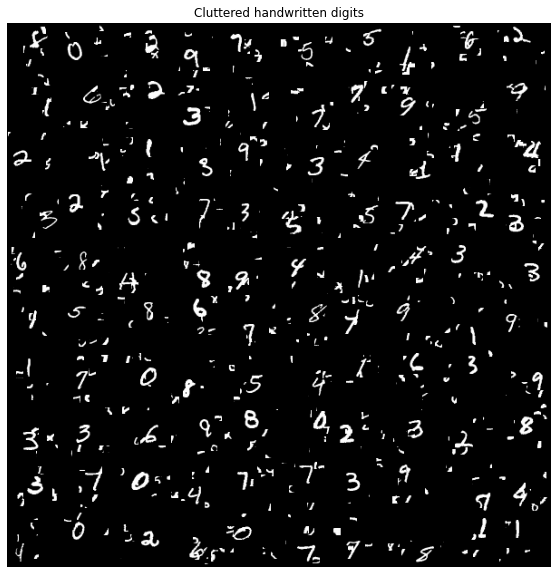

In [7]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print("Train samples:", X_train.shape)
    print("Validation samples:", X_valid.shape)
    print("Test samples:", X_test.shape)

    return dict(
        X_train=np.asarray(X_train, dtype='float32'),
        y_train=y_train.astype('int32'),
        X_valid=np.asarray(X_valid, dtype='float32'),
        y_valid=y_valid.astype('int32'),
        X_test=np.asarray(X_test, dtype='float32'),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

idx = 0
canvas = np.zeros((DIM*NUM_CLASSES, NUM_CLASSES*DIM))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

## Building the model

We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

We set up the transformer layer to initially do the identity transform, similarly to [1]. If the output from the localization networks is [t1, t2, t3, t4, t5, t6] then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and t6 move the center position. By setting the initial values of the bias vector to 

```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer. 

The output of the localization layer feeds into the transformer layer which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities.


### The model
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```




In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [9]:
class Net(nn.Module):
    
    def __init__(self, input_channels, input_height, input_width, num_classes, num_zoom=3):
        super(Net, self).__init__()
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        self.num_zoom = num_zoom
        
        # Spatial transformer localization-network
        # nn.Sequential http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        #   A sequential container. 
        #   Modules will be added to it in the order they are passed in the constructor.
        self.localization = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=8, 
                      kernel_size=7, 
                      padding=3),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, 
                      out_channels=10, 
                      kernel_size=5, 
                      padding=2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.ReLU(inplace=True)
        )

        # Regressor for the 3 * 2 affine matrix that we use 
        # to make the bilinear interpolation for the spatial transformer
        self.fc_loc = nn.Sequential(
            nn.Linear(in_features=10 * input_height//4 * input_width//4, 
                      out_features=32,
                      bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, 
                      out_features=3 * 2,
                      bias=True)
        )

        # Initialize the weights/bias with identity transformation
        # see the article for a definition and explanation for this
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])
        
        # The classification network based on the transformed (cropped) image
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=16,
                               kernel_size=5,
                               padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32,
                               kernel_size=5,
                               padding=2)
        self.conv2_drop = nn.Dropout2d()
        
        # fully connected output layers
        self.fc1_features = 32 * input_height//num_zoom//4 * input_width//num_zoom//4
        self.fc1 = nn.Linear(in_features=self.fc1_features, 
                             out_features=50)
        self.fc2 = nn.Linear(in_features=50,
                             out_features=num_classes)

    # Spatial transformer network forward function
    def stn(self, x):
        """ Spatial Transformer Network """
        # creates distributed embeddings of the image with the location network.
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.input_height//4 * self.input_width//4)
        # project from distributed embeddings to bilinear interpolation space
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        # define the output size of the cropped tensor
        # notice that we divide the height and width with the amount of zoom
        output_size = torch.Size((x.size()[0],
                                  x.size()[1], 
                                  x.size()[2]//self.num_zoom,
                                  x.size()[3]//self.num_zoom))
        # magic pytorch functions that are used for transformer networks
        grid = F.affine_grid(theta, output_size, align_corners=True) # http://pytorch.org/docs/master/nn.html#torch.nn.functional.affine_grid
        x = F.grid_sample(x, grid, align_corners=True) # http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        # save transformation
        l_trans1 = Variable(x.data)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.fc1_features)
        x = F.relu(self.fc1(x))
        # note use of Functional.dropout, where training must be explicitly defined (default: False)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return output and batch of bilinear interpolated images
        return F.log_softmax(x, dim=1), l_trans1


net = Net(1, DIM, DIM, NUM_CLASSES)
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

Net(
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=2250, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [12]:
import nest_asyncio
nest_asyncio.apply()

In [13]:
# test forward pass on dummy data
x = np.random.normal(0,1, (45, 1, 60, 60)).astype('float32')
x = Variable(torch.from_numpy(x))
if torch.cuda.is_available():
    x = x.cuda()
output = net(x)
print([x.size() for x in output])

[torch.Size([45, 10]), torch.Size([45, 1, 20, 20])]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training the model
Training convnets on CPU is painfully slow.
After 10 epochs you should see that model starts to zoom in on the digits. 

In [15]:
def train_epoch(X, y,):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    net.train()
    for i in range(num_batches):
        if i % 10 == 0:
            print("{}, ".format(i), end='')
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_tr = get_variable(Variable(torch.from_numpy(X[idx])))
        y_batch_tr = get_variable(Variable(torch.from_numpy(y[idx]).long()))

        optimizer.zero_grad()
        output, _ = net(X_batch_tr)
        batch_loss = criterion(output, y_batch_tr)
        
        batch_loss.backward()
        optimizer.step()
        
        costs.append(get_numpy(batch_loss))
        preds = np.argmax(get_numpy(output), axis=-1)
        correct += np.sum(get_numpy(y_batch_tr) == preds)
    print()
    return np.mean(costs), correct / float(num_samples)

def eval_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    pred_list = []
    transform_list = []
    net.eval()
    for i in range(num_batches):
        if i % 10 == 0:
            print("{}, ".format(i), end='')
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_val = get_variable(Variable(torch.from_numpy(X[idx])))
        output, transformation = net(X_batch_val)
        pred_list.append(get_numpy(output))
        transform_list.append(get_numpy(transformation))
    transform_eval = np.concatenate(transform_list, axis=0)
    preds = np.concatenate(pred_list, axis=0)
    preds = np.argmax(preds, axis=-1)
    acc = np.mean(preds == y)
    print()
    return acc, transform_eval

<string>:1: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited


In [16]:
n = 0

Note you can interrupt training to visualize progress along the way

In [17]:
valid_accs, train_accs, test_accs = [], [], []

while n < NUM_EPOCHS:
    n += 1
    try:
        print("Epoch %d:" % n)
        print('train: ')
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        print('valid ')
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        print('test ')
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        print("train cost {0:.2}, train acc {1:.2}, val acc {2:.2}, test acc {3:.2}".format(
                train_cost, train_acc, valid_acc, test_acc))
    except KeyboardInterrupt:
        print('\nKeyboardInterrupt')
        break

Epoch 1:
train: 
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid 
0, 10, 20, 30, 
test 
0, 10, 20, 30, 
train cost 2.2, train acc 0.16, val acc 0.22, test acc 0.22
Epoch 2:
train: 
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 
KeyboardInterrupt


### Plot errors and zoom

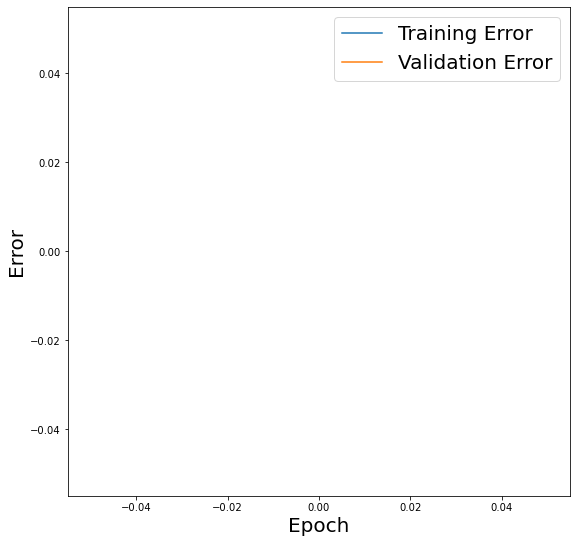

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/_pylab_helpers.py:76: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  gc.collect(1)


In [20]:
plt.figure(figsize=(9, 9))
plt.plot(1 - np.array(train_accs), label='Training Error')
plt.plot(1 - np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

NameError: name 'data' is not defined

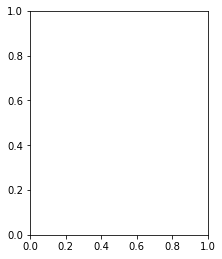

In [21]:
plt.figure(figsize=(7, 14))
for i in range(3):
    plt.subplot(321 + i * 2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

# A few pointers for image classification

If you want do image classification, using a pretrained model is often a good choice, especially if you have limited amounts of labelled data.
PyTorch has a 
[guide for using their current state-of-the-art pretrained model](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) in their 
[model repository](https://github.com/pytorch/vision/tree/master/torchvision/models).
Torch7 has [an interesting blog post about residual nets](http://torch.ch/blog/2016/02/04/resnets.html), an architecture that was very popular and influential a while back.